In [1]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.stats 

In [3]:
pd.set_option('precision', 10)

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
np.set_printoptions(suppress=True)

# Objectives

1) Create a weighted by cohort size retention curve where the x-axis = Days since install ; y-axis = weighted retention value

2) Fit various statistical functions modelling the  weighted by cohort size retention curve. i.e. $f( D_{x} )=retention$ where $D_{x}$ is days since install and use $f( D_{x} )$ to calculate predicted DAU

3) Plot actual vs predicted DAU

In [6]:
Data = pd.read_csv('weborders_agg_2020_08_11.csv')

In [7]:
Data.tail(5)

,DATE,DNU,Revenue,DAU,D1,D7,D14,D30,D60,D90,D180,D365,D540,D730,D1095,D1460,D1600,country,platform
1464,2017-08-21,201,29008.6200000001,444,0.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global,All
1465,2017-08-22,223,34650.6700000001,449,0.0089686099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global,All
1466,2017-08-23,216,34647.2500000001,471,0.0046296296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global,All
1467,2017-08-24,168,26943.5000000001,375,0.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global,All
1468,2017-08-25,82,15670.3000000000,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global,All


# Weighted Cohort Calculation

We need to calculate the $\textit{weighted by cohort size retention curve over days-since-install for cohorts}$ . I.e. where there are duplicate days with the data, we take the weighted daily average of retention values ( weighted by each days DNU values)

Example calculation:

20 Mar D1 = 50% DNU = 150 ; 20 Mar D1 = 75% DNU = 120 ; Weighted D1 = $(\frac{150}{(150+120)})(\frac{50}{100}) + (\frac{120}{(150+120)})(\frac{75}{100}) $

### Check for duplicate dates

Looks like all the dates are unique.

In [8]:
Data.DATE.unique().shape

(1469,)

In [9]:
Data.DATE.values.shape

(1469,)

In [10]:
Data.shape

(1469, 19)

No need to calculated daily weights for day since install retentions

# Look at column statistics

Look at statistics of non-nan values

In [11]:
Data.describe()

,DNU,Revenue,DAU,D1,D7,D14,D30,D60,D90,D180,D365,D540,D730,D1095,D1460,D1600
count,1469.0000000000,1469.0000000000,1469.0000000000,1468.0000000000,1462.0000000000,1455.0000000000,1439.0000000000,1409.0000000000,1379.0000000000,1289.0000000000,1104.0000000000,929.0000000000,739.0000000000,374.0000000000,10.0,1.0
mean,141.0844111641,15993.8407351940,239.2355343771,0.0044918570,0.0060344834,0.0037285194,0.0035152530,0.0019029279,0.0023870170,0.0019138743,0.0021282291,0.0015081090,0.0018774343,0.0013879086,0.0,0.0
std,135.5353386382,14733.8560507554,226.6493987095,0.0086755623,0.0282554697,0.0079851632,0.0274459631,0.0055194846,0.0076478151,0.0065246963,0.0072788550,0.0063287314,0.0077082928,0.0066950644,0.0,NaN
min,1.0000000000,12.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
25%,43.0000000000,4846.6500000000,65.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
50%,102.0000000000,11182.9000000000,164.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
75%,195.0000000000,23011.9500000001,347.0000000000,0.0062208851,0.0070921986,0.0048780488,0.0019477318,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
max,937.0000000000,115497.5999999998,1447.0000000000,0.0714285714,1.0000000000,0.0740740741,1.0000000000,0.0588235294,0.1250000000,0.0769230769,0.1250000000,0.0666666667,0.1000000000,0.0500000000,0.0,0.0


## Remove some outliers

In [12]:
Data.shape

(1469, 19)

In [13]:
Data = Data[Data['D7']<0.999]
Data = Data[Data['D30']<0.999]

In [14]:
Data.shape

(1437, 19)

In [15]:
Data.describe()

,DNU,Revenue,DAU,D1,D7,D14,D30,D60,D90,D180,D365,D540,D730,D1095,D1460,D1600
count,1437.0000000000,1437.0000000000,1437.0000000000,1437.0000000000,1437.0000000000,1437.0000000000,1437.0000000000,1407.0000000000,1377.0000000000,1287.0000000000,1102.0000000000,927.0000000000,737.0000000000,372.0000000000,8.0,1.0
mean,138.3472512178,15565.3422825331,232.7216423104,0.0045145298,0.0053799017,0.0037577644,0.0028242512,0.0019056329,0.0023904840,0.0019168485,0.0021320916,0.0015113627,0.0018825291,0.0013953705,0.0,0.0
std,133.5438847926,14334.4491480492,220.5560279391,0.0087500582,0.0111126942,0.0080269214,0.0078963327,0.0055229419,0.0076528292,0.0065293311,0.0072848974,0.0063351737,0.0077181368,0.0067123085,0.0,NaN
min,1.0000000000,12.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
25%,43.0000000000,4756.1400000000,65.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
50%,96.0000000000,10778.7500000000,156.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
75%,191.0000000000,21874.3000000001,335.0000000000,0.0062500000,0.0070921986,0.0050000000,0.0019230769,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0,0.0
max,937.0000000000,115497.5999999998,1447.0000000000,0.0714285714,0.2000000000,0.0740740741,0.1111111111,0.0588235294,0.1250000000,0.0769230769,0.1250000000,0.0666666667,0.1000000000,0.0500000000,0.0,0.0


### Check if categorical cols have any information value

In [16]:
Data.country.unique()

array(['Global'], dtype=object)

In [17]:
Data.platform.unique()

array(['All'], dtype=object)

Looks like the country and platform columns are redundant

Assuming that the D{1,7,14,..1600} retention values are percentages i.e. 0.0044918570 = 0.4491857 %

In [18]:
SortedData = Data.sort_values( by = 'DATE',ascending = False )

Going to replace nan values with 0. i.e. Assuming that non retention values = 0.0% retention

In [19]:
SortedData = SortedData.set_index('DATE')

In [20]:
# Assume that default retention values are nil

CohortsColumns = ['D1','D7','D14','D30','D60','D90','D180','D365','D540','D730','D1095','D1460','D1600']
for CohortCol in CohortsColumns:
    SortedData[CohortCol].fillna(0.0,inplace=True)

Plot the hisogram for the Dx features with and without the "0" bucket

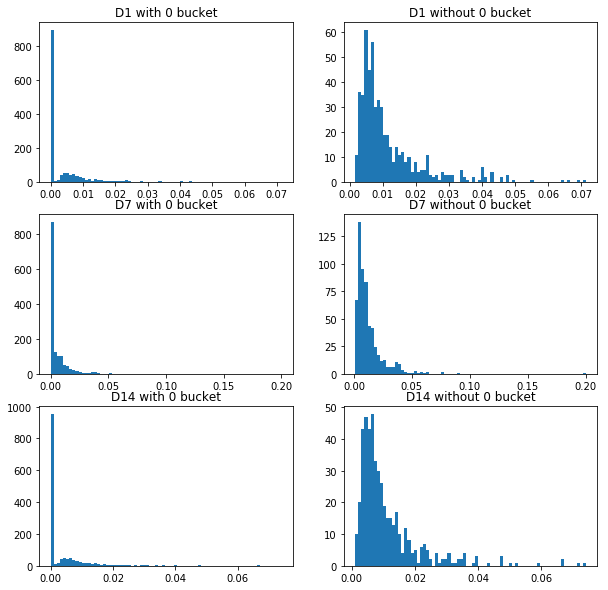

In [21]:
N_bins = 75
fig, ax = plt.subplots(3, 2,figsize = (10,10))
ax[0,0].hist(SortedData.D1,N_bins)
ax[0,0].title.set_text('D1 with 0 bucket')
ax[0,1].hist(SortedData[SortedData['D1']>0].D1,N_bins)
ax[0,1].title.set_text('D1 without 0 bucket')
ax[1,0].hist(SortedData.D7,N_bins)
ax[1,0].title.set_text('D7 with 0 bucket')
ax[1,1].hist(SortedData[SortedData['D7']>0.0].D7,N_bins)
ax[1,1].title.set_text('D7 without 0 bucket')

ax[2,0].hist(SortedData.D14,N_bins)
ax[2,0].title.set_text('D14 with 0 bucket')

ax[2,1].hist(SortedData[SortedData['D14']>0].D14,N_bins)
ax[2,1].title.set_text('D14 without 0 bucket')

plt.show()

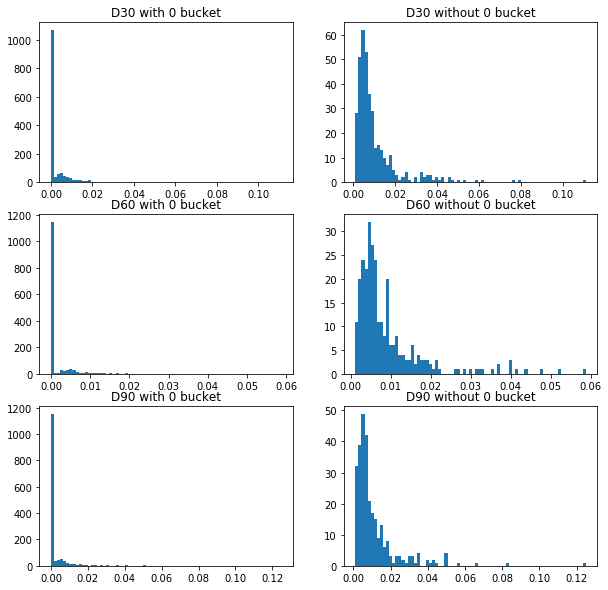

In [22]:
N_bins = 75
fig, ax = plt.subplots(3, 2,figsize = (10,10))
ax[0,0].hist(SortedData.D30,N_bins)
ax[0,0].title.set_text('D30 with 0 bucket')
ax[0,1].hist(SortedData[SortedData['D30']>0.0].D30,N_bins)
ax[0,1].title.set_text('D30 without 0 bucket')
ax[1,0].hist(SortedData.D60,N_bins)
ax[1,0].title.set_text('D60 with 0 bucket')
ax[1,1].hist(SortedData[SortedData['D60']>0].D60,N_bins)
ax[1,1].title.set_text('D60 without 0 bucket')
ax[2,0].hist(SortedData.D90,N_bins)
ax[2,0].title.set_text('D90 with 0 bucket')
ax[2,1].hist(SortedData[SortedData['D90']>0].D90,N_bins)
ax[2,1].title.set_text('D90 without 0 bucket')


plt.show()

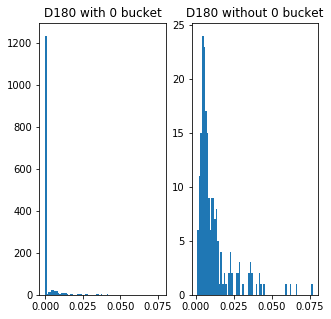

In [23]:
N_bins = 75
fig, ax = plt.subplots(1, 2,figsize = (5,5))
ax[0].hist(SortedData.D180,N_bins)
ax[1].hist(SortedData[SortedData['D180']>0].D180,N_bins)
ax[1].title.set_text('D180 without 0 bucket')
ax[0].title.set_text('D180 with 0 bucket')

plt.show()

## Set up date ranges data.

Use: 
(Current date - last 210 days for training ,Current date - last 30 days for training) for training the data


In [24]:
NewestDate = SortedData.head(1).index[0]

In [25]:
OldestDate = (datetime.strptime(NewestDate, '%Y-%m-%d') - timedelta(days=211)).strftime('%Y-%m-%d')

In [26]:
LastTrainingDate = (datetime.strptime(NewestDate, '%Y-%m-%d') - timedelta(days=30)).strftime('%Y-%m-%d')

In [27]:
print('NewestDate == {}'.format(NewestDate))
print('OldestDate == {}'.format(OldestDate))
print('LastTrainingDate == {}'.format(LastTrainingDate))

NewestDate == 2017-07-26
OldestDate == 2016-12-27
LastTrainingDate == 2017-06-26


In [28]:
#DataRecords = SortedData.to_dict(orient = 'index')

# Calculating Weighted by cohort size retention

![title](img/DaysSinceInstall.png)

Above is what the $\textit{weighted by cohort size retention curve over days-since-install for cohorts}$ should look like. For every $\textit{Days Since Install}$ x-value , there is exactly one y-value. 

$\textbf{Assumption:}$ Assuming in order to create the above the curve Im going to take the mean D1,D7,D14,D30,D60,D90,D180 values

e.g. $\langle (D1^{0}, R^{0}),(D1^{1}, R^{1}),
(D1^{2}, R^{2}),...,(D1^{N}, R^{N}) \rangle \mapsto D1 : \frac{1}{N} \sum_{i}^{N} R^{i}$

# Preprocessing

In [29]:
SortedData.reset_index(inplace = True)
CurveData = SortedData[(SortedData['DATE']>OldestDate) & (SortedData['DATE']<LastTrainingDate)]
InferenceData = SortedData[SortedData['DATE']>OldestDate]

In [30]:
print(CurveData.shape)
print(InferenceData.shape)

(180, 19)
(211, 19)


In [31]:
SUM_DNU = CurveData.DNU.sum()

# Empirical Distribution

## First approach: Not imputting any missing data (e.g. D2) instead we only work with the days since install data we have and construct a retention curve from that

In [32]:
AggCurveRententions = SortedData.agg({'D1' : [np.mean], 'D7' : [np.mean],
               'D14' : [np.mean], 'D30' : [np.mean],
               'D60' : [np.mean],'D90' : [np.mean],
               'D180' : [np.mean]
              }).T * 100

In [33]:
AggCurveRententions['DaySinceInstall'] = [1,7,14,30,60,90,180]

In [34]:
AggCurveRententions

,mean,DaySinceInstall
D1,0.4514529753,1
D7,0.5379901674,7
D14,0.3757764355,14
D30,0.2824251237,30
D60,0.1865849286,60
D90,0.2290672514,90
D180,0.1716759911,180


In [35]:
AggCurveRententions = AggCurveRententions.set_index('DaySinceInstall')

## Note

The retention values seem really low. For example $D_{1} = 0.0.4514529753$ % = 0.004514529753. 

Need to double check if the I'm interpreting the rentention values correctly

# Retention Curve

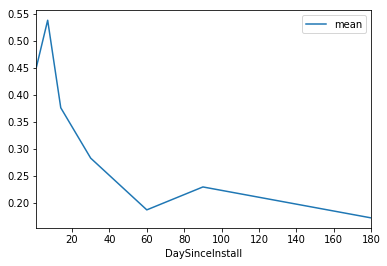

In [36]:
AggCurveRententions.plot()

In [37]:
AggCurveRententions['mean'].values

array([0.45145298, 0.53799017, 0.37577644, 0.28242512, 0.18658493,
       0.22906725, 0.17167599])

In [38]:
DaysWithRetention = {'D'+str(i):val for i,val in zip([1,7,14,30,60,90,180],AggCurveRententions['mean'].values)}

In [39]:
DatawithDefaults = {'D'+ str(i):DaysWithRetention.get('D'+ str(i),0.00) for i in range(1,181)}

In [40]:
RentionVals = list(DatawithDefaults.values())

In [41]:
days_since_install = [i for i in range(1,181)]

### View data as bar plot

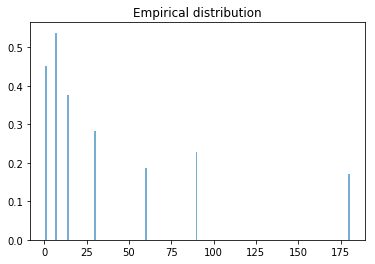

In [42]:
fig, ax = plt.subplots(1, 1)
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6)
ax.title.set_text('Empirical distribution')

In [43]:
datum = AggCurveRententions['mean'].values
datum

array([0.45145298, 0.53799017, 0.37577644, 0.28242512, 0.18658493,
       0.22906725, 0.17167599])

## Remarks

1) The data distribution is positve skewed. 

2) 

Many of the positve skewed , long tail distributions belong to the Tweedie distribution,

This includes the gamma distribution, Inverse Gaussian and scaled Poisson distributions

https://en.wikipedia.org/wiki/Tweedie_distribution

We going to try:

Appoarch 1) model the data by a constant multiplied by a distribution from the Tweedie family

i.e Modelling the retention curve by a Tweedie long tail statisical distribution.$Cf(x)$ where $f(x)$ is a pdf and $C \in \mathbb{R}^{+}$

Appoarch 2) try GLM based on one of the distributions from the same family

## Trying different long tail distributions

# Weibull distribution

In [44]:

c =1.7120999
weibull_loc = 0.
weibull_scale = 12.534234

In [45]:
# C = 10
Weibull_Variates = scipy.stats.distributions.weibull_min.pdf(days_since_install, c,weibull_loc,weibull_scale) * 10

<BarContainer object of 180 artists>

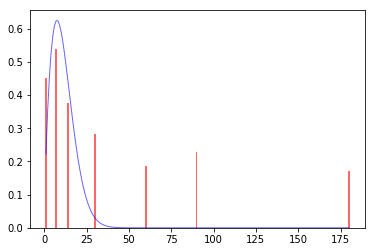

In [46]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,Weibull_Variates, lw=1, alpha=0.6, label='weibull_min pdf',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

# Inverse Gaussian

In [47]:
InverseGauss_mu = 3750.255
InverseGauss_loc = 1.645
InverseGauss_scale = 9.2385



In [48]:
# C = 10
InverseGauss_Variates = scipy.stats.distributions.invgauss.pdf(days_since_install, InverseGauss_mu
                                                               ,InverseGauss_loc,
                                                               InverseGauss_scale) * 10

<BarContainer object of 180 artists>

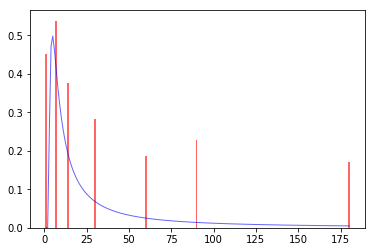

In [49]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,InverseGauss_Variates, lw=1, alpha=0.6, label='InverseGauss Variates pdf',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

# Pareto Distribution

In [50]:
Pareto_b = .089115
Pareto_loc = 0.0
Pareto_scale = 1.08434#0.1912142



In [51]:
# C = 10
Pareto_Variates = scipy.stats.distributions.pareto.pdf(days_since_install, Pareto_b
                                                               ,Pareto_loc,
                                                               Pareto_scale) * 10

<BarContainer object of 180 artists>

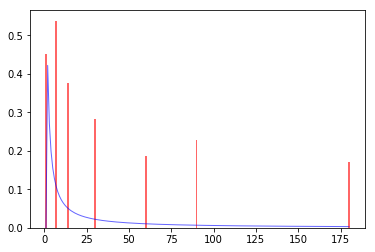

In [52]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,Pareto_Variates, lw=1, alpha=0.6, label='Pareto Variates Variates pdf',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

# Log normal

In [53]:
LogNormal_s = 0.8905
LogNormal_loc = 0.6783456#np.log(100000)
LogNormal_scale =np.log(9000)

In [54]:
# C = 10
LogNormal_Variates = scipy.stats.distributions.lognorm.pdf(days_since_install, LogNormal_s
                                                               ,LogNormal_loc,
                                                               LogNormal_scale) * 7


<BarContainer object of 180 artists>

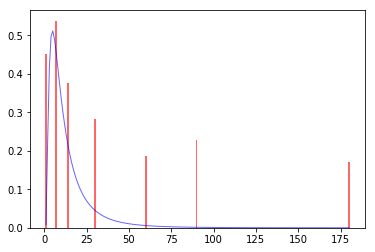

In [55]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,LogNormal_Variates, lw=1, alpha=0.6, label='LogNormal Variates',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='LogNormal', color = 'red')

### Choosing the final distribution 

Going with Weibull distribution

# Generalized Linear Models (GLM)

Lets try fit some GLMs. We're going to keep the Tweedie family of models as many long tail distributions belong to it

In [56]:
x = np.asarray([1,7,14,30,60,90,180])
y =AggCurveRententions['mean'].values
y = np.asarray([val if (val > 0.005) else 0.005 for val in y])

In [57]:
TrainData = pd.DataFrame(np.asarray([i for i in range(1,181)]))

## Poisson Family Regression

In [58]:
PoissonRegression = TweedieRegressor(power=1, alpha=4.324e-5, link='log', max_iter=50000,fit_intercept = False)


In [59]:
PoissonRegression.fit(
    pd.DataFrame(x),
    y)

TweedieRegressor(alpha=4.324e-05, fit_intercept=False, link='log',
                 max_iter=50000, power=1)

In [60]:
PoissonPredictions = PoissonRegression.predict(TrainData)

<BarContainer object of 180 artists>

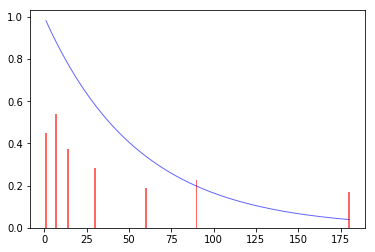

In [61]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,PoissonPredictions, lw=1, alpha=0.6, label='LogNormal Variates',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

## Gamma Family Regression

In [62]:
GammaDist = GammaRegressor(alpha=4.51243e-15, max_iter=100000,fit_intercept = False) # 125

GammaDist.fit(
    pd.DataFrame(x),
    y)

GammaRegressor(alpha=4.51243e-15, fit_intercept=False, max_iter=100000)

In [63]:
GammPredictions = GammaDist.predict(TrainData)

<BarContainer object of 180 artists>

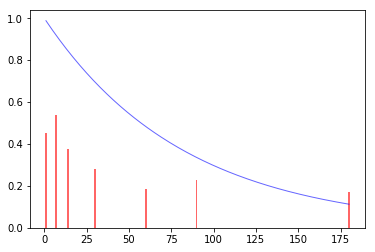

In [64]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,GammPredictions, lw=1, alpha=0.6, label='LogNormal Variates',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

## Inverse Gaussian Regression

In [65]:
y0 = np.asarray([val if (val > 0.005) else 0.005 for val in y])

In [66]:
InverseGaussian = TweedieRegressor(power=3, alpha=4.324e1, link='log', max_iter=10000,fit_intercept = False)


In [67]:
InverseGaussian.fit(
    pd.DataFrame(x),
    y)

TweedieRegressor(alpha=43.24, fit_intercept=False, link='log', max_iter=10000,
                 power=3)

In [68]:
InverseGaussianPredictions = InverseGaussian.predict(TrainData)

<BarContainer object of 180 artists>

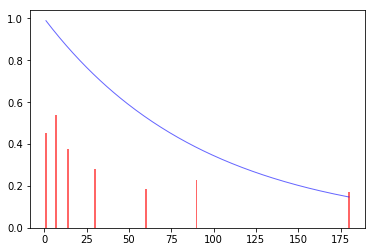

In [69]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,InverseGaussianPredictions, lw=1, alpha=0.6, label='LogNormal Variates',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

# Hybird model

Different behaviours we're trying to capture. The $Cf(x)$ appoarch works well when the days since install is small but the distribution tapers off quickly . The regression $R(x)$ approach works well when the days since install is higher but severely over estimates the retention values for small values of days since install (less than 25 days)

I believe the best model for this problem is a piece-wise function where the for small values we use the $Cf(x)$ distribution approach and for larger values of days since install we use the $R(x)$ regression approach

In [70]:
Begining = list(Weibull_Variates[:20])

In [71]:
MidSection = list((Weibull_Variates[20:100] + InverseGaussianPredictions[20:100]) * (1/2))

In [72]:
EndSection = list(InverseGaussianPredictions[100:])

In [73]:
HybirdModel = Begining + MidSection + EndSection
HybirdModel = np.asarray(HybirdModel)

<BarContainer object of 180 artists>

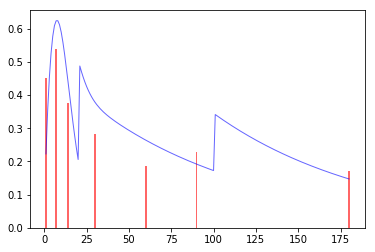

In [74]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,HybirdModel, lw=1, alpha=0.6, label='LogNormal Variates',color = 'blue')
ax.bar(days_since_install,RentionVals, lw=1, alpha=0.6, label='weibull_min pdf', color = 'red')

$f(x) = \begin{cases} CW(x) &\mbox{if } x \in [0,25] \\
\frac{(Cf(x) + InvGauss(x))}{2} & \mbox{if } x \in [25,100]  \\
InvGauss(x) &\mbox{if } x \gt 100 \end{cases}$ 

Where 

$C = 10$

$W(x)$ is the Weibull distribution

$InvGauss(x)$ Is Inverse Gaussian Regression model

In [75]:
HybirdRegressionRentetionValues = {'D'+ str(day_since_install):HybirdModel[day_since_install-1]/100 for day_since_install in [1,7,14,30,60,90,180]}

# Predictions

## Example DAU calculation

![title](img/CalculationExample.png)

In [76]:
130 * (100/100) + 120 * (34/100) + 110 * (45/100) + 100 * (34/100)
#21Mar * D0.      20Mar * D1       20Mar * D2       19Mar * D3

254.3

### Question / Notes

Should it not be :

#21Mar * D0(K19)      20Mar * D1(L18)       20Mar * D1(L17)       19Mar * D2(M16)



We only have $D_{1},D_{7},...D_{1600}$ . We are not given retention data for every day since install. i.e. We are not given $D_{2}, D_{3}$ for example

# Plot Hybird model predictions

In [77]:
PredictionLookBack = (datetime.strptime(NewestDate, '%Y-%m-%d') - timedelta(days=180)).strftime('%Y-%m-%d')

In [78]:
PredictionData = SortedData[SortedData['DATE']>PredictionLookBack]

In [79]:
PredictionData.set_index('DATE', inplace = True)

In [80]:
PredictionData['Regression_D1'] = HybirdRegressionRentetionValues['D1']
PredictionData['Regression_D7'] = HybirdRegressionRentetionValues['D7']
PredictionData['Regression_D14'] = HybirdRegressionRentetionValues['D14']
PredictionData['Regression_D30'] = HybirdRegressionRentetionValues['D30']
PredictionData['Regression_D60'] = HybirdRegressionRentetionValues['D60']
PredictionData['Regression_D90'] = HybirdRegressionRentetionValues['D90']
PredictionData['Regression_D180'] = HybirdRegressionRentetionValues['D180']

/Users/paballomoeletsi/.virtualenvs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/paballomoeletsi/.virtualenvs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/paballomoeletsi/.virtualenvs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [81]:
PredictionData.shape

(180, 25)

In [82]:
CurvePredictionRecords = PredictionData.to_dict(orient = 'index')


In [83]:
def MakePredictedDNUDataset(DataRecords,DxLookback = [1,7,14,30,60,90,180],
                           DistributionCurveVal = 'Weibull_D',PredictedDNU_column = 'WeibullPrediction'):
    
    for CurrentDay in DataRecords.keys():
        
        days = [[(datetime.strptime(CurrentDay, '%Y-%m-%d') - timedelta(days=daylookback)).strftime('%Y-%m-%d'),
                 DistributionCurveVal+ str(daylookback)]
            for daylookback in DxLookback]


        WeightedDNU = 0.0
        for daylookback,column in days:
            try:
                WeightedDNU = WeightedDNU + DataRecords[daylookback][column] * DataRecords[daylookback]['DNU'] 
            except KeyError:
                pass
                
    
        DataRecords[CurrentDay][PredictedDNU_column+'_'+'HistoricDNUContribution'] = WeightedDNU
        DataRecords[CurrentDay][PredictedDNU_column] = DataRecords[CurrentDay]['DNU'] + WeightedDNU
    
    return DataRecords

In [84]:
PredictionData.sample(1)

,DNU,Revenue,DAU,D1,D7,D14,D30,D60,D90,D180,D365,D540,D730,D1095,D1460,D1600,country,platform,Regression_D1,Regression_D7,Regression_D14,Regression_D30,Regression_D60,Regression_D90,Regression_D180
DATE,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-22,281,35837.1,517,0.0071174377,0.0035587189,0.0035587189,0.0035587189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Global,All,0.0022271607,0.0062385636,0.0044137301,0.0037809752,0.0026402498,0.0019185811,0.0014723814


In [85]:
PredictionRecords = MakePredictedDNUDataset(CurvePredictionRecords,DistributionCurveVal = 'Regression_D',
                                           PredictedDNU_column = 'PredictedDAU')

In [86]:
PredictionData = pd.DataFrame.from_dict(PredictionRecords, orient = 'index')

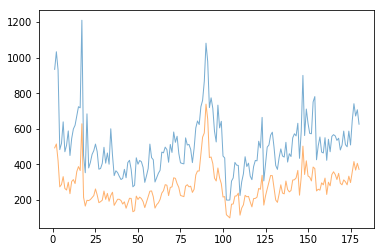

In [87]:
fig, ax = plt.subplots(1, 1)
ax.plot(days_since_install,PredictionData.DAU.values[:180], lw=1, alpha=0.6, label='weibull_min pdf')
ax.plot(days_since_install,PredictionData.PredictedDAU.values[:180], lw=1, alpha=0.6, label='WeibullPrediction pdf')

In [88]:
PredictionData[['DAU','DNU','PredictedDAU','PredictedDAU_HistoricDNUContribution','Regression_D7','D7']].describe()

,DAU,DNU,PredictedDAU,PredictedDAU_HistoricDNUContribution,Regression_D7,D7
count,180.0000000000,180.0000000000,180.0000000000,180.0000000000,180.0000000000,180.0000000000
mean,506.0833333333,271.2000000000,276.1067811767,4.9067811767,0.0062385636,0.0048554868
std,161.4116454093,98.8001990363,98.8209295771,1.3872593113,0.0000000000,0.0046742801
min,199.0000000000,95.0000000000,99.1659208776,0.0000000000,0.0062385636,0.0000000000
25%,405.7500000000,205.0000000000,209.2395470145,4.2083067280,0.0062385636,0.0000000000
50%,482.0000000000,254.5000000000,260.0779690112,4.8799611717,0.0062385636,0.0041943653
75%,575.7500000000,319.0000000000,323.0622652040,5.6350163307,0.0062385636,0.0070601852
max,1210.0000000000,732.0000000000,738.5894309742,9.1844835340,0.0062385636,0.0231660232


# Loss

In [89]:
Groundtruths = PredictionData.DAU.values
Predictions = PredictionData.PredictedDAU.values

### RMSE

In [90]:
BaselineDeltas = Groundtruths - Groundtruths.mean()
SqauredBaselineDeltas = BaselineDeltas**2
np.sqrt(SqauredBaselineDeltas.sum())

2159.5406340238196

In [91]:
RegressionDeltas = Predictions - Groundtruths
SquaredDeltas = RegressionDeltas**2
np.sqrt(SquaredDeltas.sum())

3245.727369610009

RMSE is lower for the baseline model but this does not take into account the high variance of the ground truth data. 

### Thoughts

It looks like the main contribution to the predicted DAU is the DNU i.e. the weighted contribution of DNU from previous days install $DNU \times D_{x}$  = Predict $x \in [1,7,14,30,60,90,180]$  has very small contributions to the overall prediction value, The largest contributor to the prediction is the DNU on the current day. This because the predicted retention AND actual retention values are extremely small (see the mean Predicted D7= 0.0062385636 and mean actual D7 = 0.0048554868).

Multiplying the DNU by the small retention values results in small contributions to the over all predicted DAU values.

This issue could be compensated by increasing the number of days since install columns. This will compensate the small contributions by summing many of them. 


### Data imputation

### Issue with data

We only provided the columns D1,D7,D14,D30,D60,D90,D180. 

The graph below shows that we are missing many data points (D2,D3,D33,D178...). One approach we could use is imputing the missing data 

![title](img/DaysSinceInstall.png)

$D_{2}$  ( 2 days after install) is currently not in the dataset. We use the following strategy impute a $D_{2}$ value

Assuming t is the current date for we would like to impute the value $D_{2}$ . e.g. if t = 2020-01-20 then $D_{2} = D_{2020-01-22}$

$D_{2}^{\text {imputed for day t}} = [ D_{1}^{t+2days+1days} \times 0.95 + D_{7}^{t+2days+7days} \times 0.95^7 ... D_{180}^{t+2days+180days} \times 0.95^{180}] \times \frac{1}{\sum_{1,7,14,30,60,90,180} 0.95^i}$

For this excercise I wont actually go impute the data but it's just one idea I could've tried to better improve the model